In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from keras.preprocessing import image
import random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.applications import resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import keras

import warnings
import matplotlib.pyplot as plt
import cv2

2024-05-30 18:55:07.183295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-05-30 18:55:07.183489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-05-30 18:55:07.348873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def data_prep(parasitized,uninfected, limit):

    parasitized= ["/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized[:limit]]
    uninfected= ["/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected[:limit]]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

df = data_prep(os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized'), os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected'), limit = 2500)
df.head()

,Image_Path,Labels
0,/kaggle/input/cell-images-for-detecting-malari...,parasitized
1,/kaggle/input/cell-images-for-detecting-malari...,parasitized
2,/kaggle/input/cell-images-for-detecting-malari...,parasitized
3,/kaggle/input/cell-images-for-detecting-malari...,parasitized
4,/kaggle/input/cell-images-for-detecting-malari...,parasitized


/tmp/ipykernel_33/3900655571.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

  ax0.text(i, label_counts[i] / 2, str(label_counts[i]), ha='center', va='center', color='white', fontsize=12)

/tmp/ipykernel_33/3900655571.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

  ax1.text(i, train_counts[i] / 2, str(train_counts[i]), ha='center', va='center', color='white', fontsize=12)

/tmp/ipykernel_33/3900655571.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

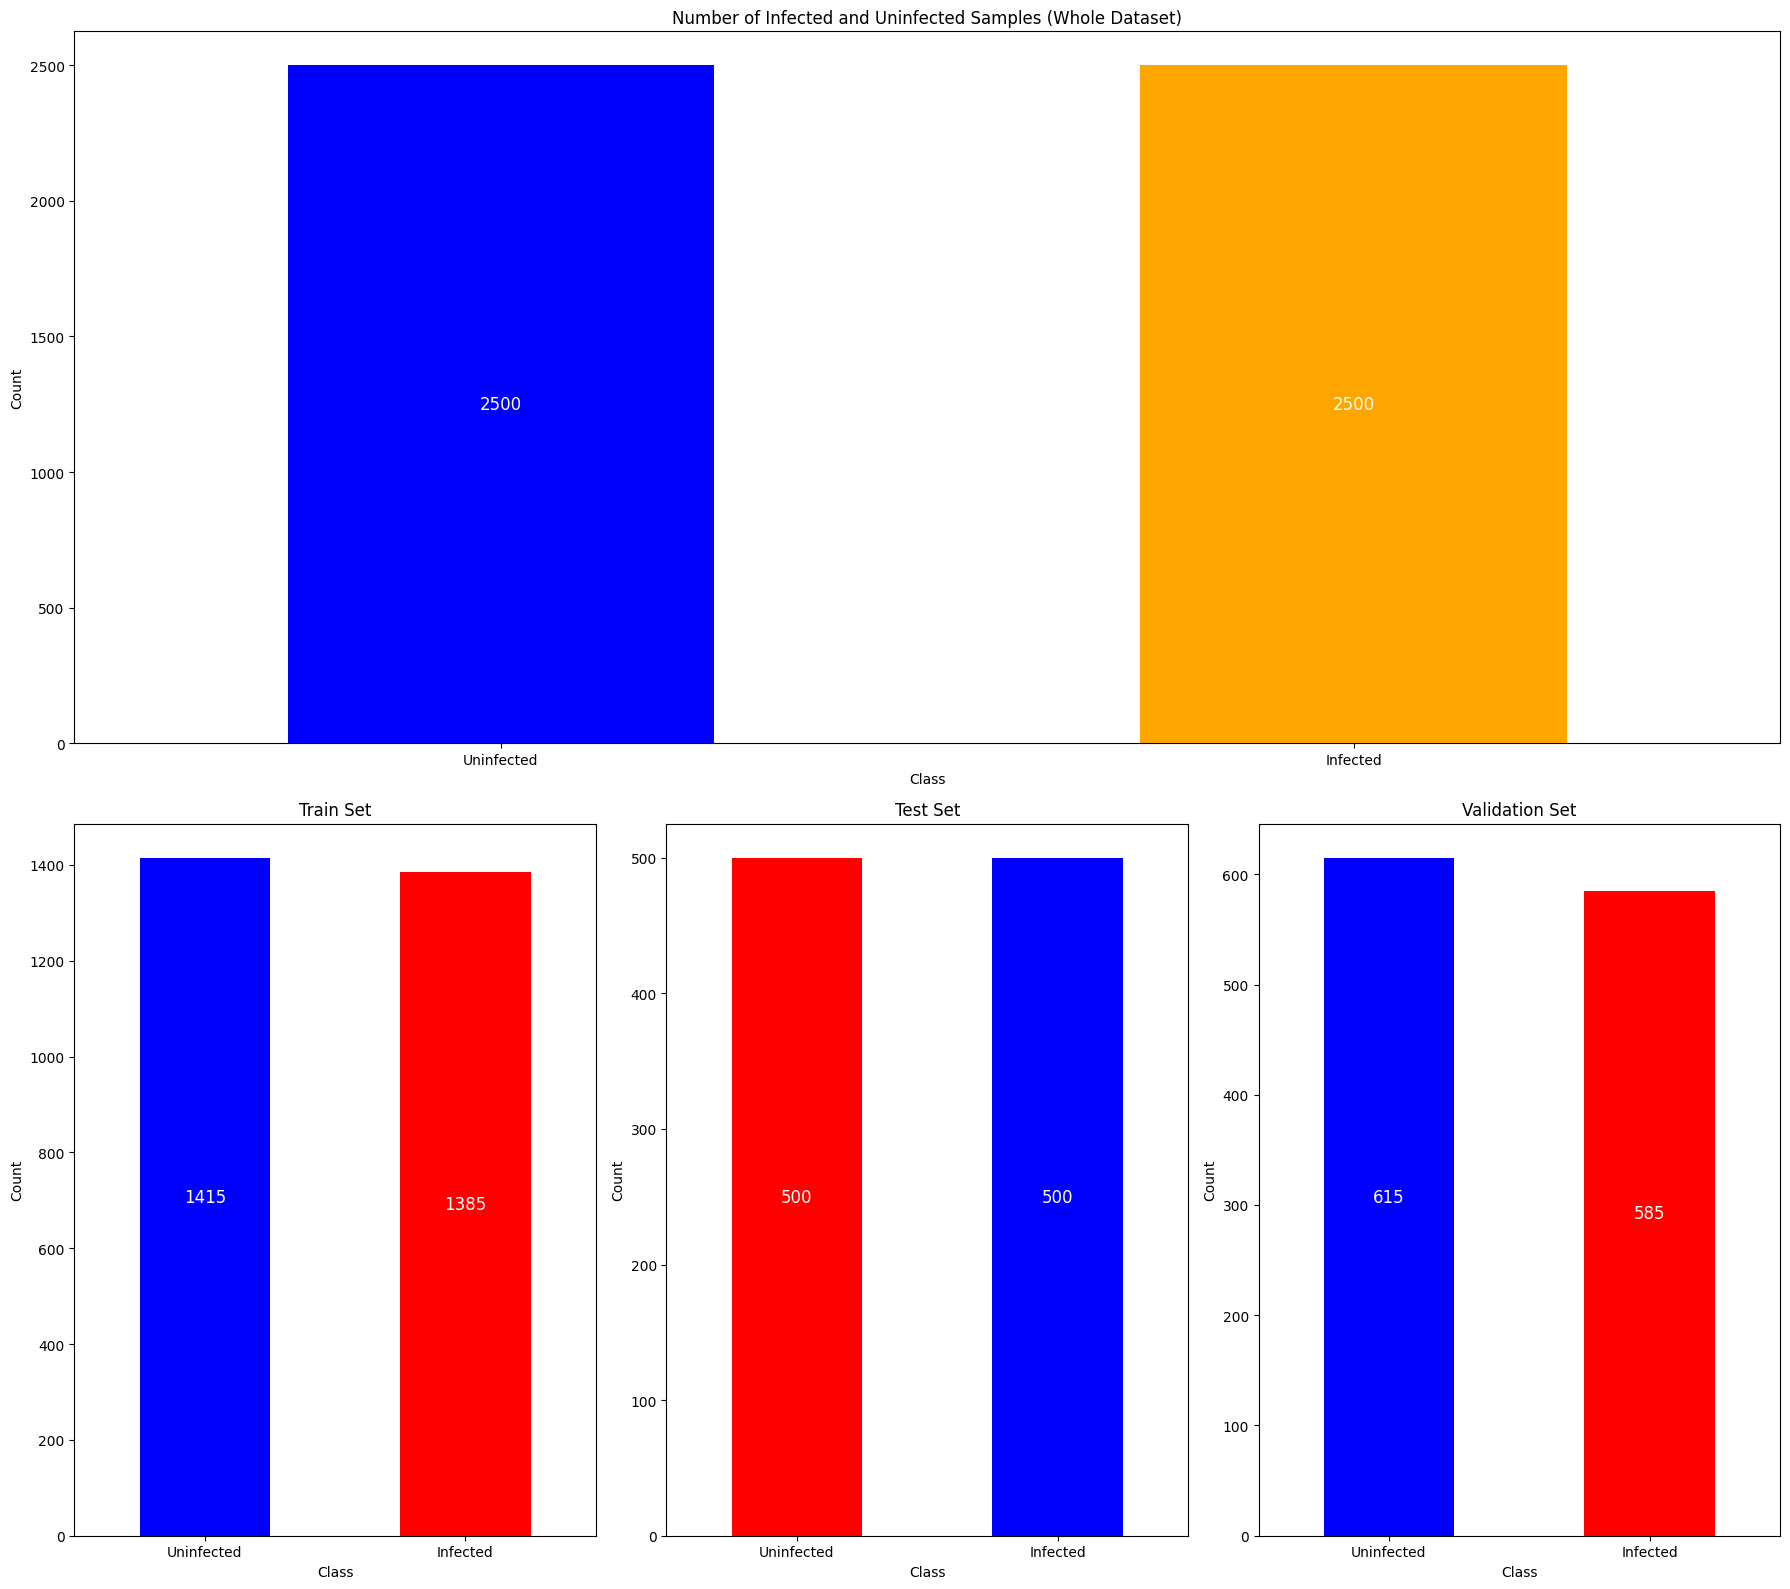

In [19]:
label_counts = df['Labels'].value_counts()

train, test = train_test_split(df, test_size=0.20, random_state=42)
train, val = train_test_split(train, test_size=0.30, random_state=42)

train_counts = train['Labels'].value_counts()
test_counts = test['Labels'].value_counts()
val_counts = val['Labels'].value_counts()

fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, :])
label_counts.plot(kind='bar', color=['blue', 'orange'], ax=ax0)
ax0.set_title('Number of Infected and Uninfected Samples (Whole Dataset)')
ax0.set_xlabel('Class')
ax0.set_ylabel('Count')
ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Uninfected', 'Infected'], rotation=0)
for i in range(len(label_counts)):
    ax0.text(i, label_counts[i] / 2, str(label_counts[i]), ha='center', va='center', color='white', fontsize=12)

ax1 = fig.add_subplot(gs[1, 0])
train_counts.plot(kind='bar', color=['blue', 'red'], ax=ax1)
ax1.set_title('Train Set')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Uninfected', 'Infected'], rotation=0)
for i in range(len(train_counts)):
    ax1.text(i, train_counts[i] / 2, str(train_counts[i]), ha='center', va='center', color='white', fontsize=12)

ax2 = fig.add_subplot(gs[1, 1])
test_counts.plot(kind='bar', color=['red', 'blue'], ax=ax2)
ax2.set_title('Test Set')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Uninfected', 'Infected'], rotation=0)
for i in range(len(test_counts)):
    ax2.text(i, test_counts[i] / 2, str(test_counts[i]), ha='center', va='center', color='white', fontsize=12)

ax3 = fig.add_subplot(gs[1, 2])
val_counts.plot(kind='bar', color=['blue', 'red'], ax=ax3)
ax3.set_title('Validation Set')
ax3.set_xlabel('Class')
ax3.set_ylabel('Count')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Uninfected', 'Infected'], rotation=0)
for i in range(len(val_counts)):
    ax3.text(i, val_counts[i] / 2, str(val_counts[i]), ha='center', va='center', color='white', fontsize=12)

plt.tight_layout()
plt.show()

# print("Displaying Parasitized Image: ")
print()
plt.figure(figsize = (12,12))
for i in range(1):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'parasitized']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Displaying Uninfected Image: ")
print()
plt.figure(figsize = (12,12))
for i in range(1):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'uninfected']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()

In [6]:
img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
]

In [8]:
def plot_history(history, model):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {model}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for {model}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
vgg_weight = '/kaggle/input/vgg-weight/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

def vgg19_model(df,train, val, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(dataframe=train, x_col='Image_Path', y_col='Labels', class_mode='binary', target_size=(224,224), shuffle=True, batch_size = 10,seed=10)
    x_val = img_datagen.flow_from_dataframe(dataframe=val,x_col='Image_Path',y_col='Labels',class_mode='binary',target_size=(224, 224),shuffle=True,batch_size = 10,seed=10)
    x_test = img_datagen.flow_from_dataframe(dataframe=test, x_col = 'Image_Path', y_col = 'Labels', class_mode = 'binary', target_size = (224, 224), shuffle = False, batch_size = 10, seed = 10)
    vgg19_model = VGG19(input_shape=(224,224,3), weights = vgg_weight, include_top=False)

    for layer in vgg19_model.layers:
        layer.trainable = False

    model = Sequential([
        vgg19_model,
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, steps_per_epoch=25, validation_data=x_val, epochs=10, callbacks=my_callbacks)

    y_pred = model.predict(x_test)
    y_pred_binary = np.round(y_pred)
    
    # Calculate the F1-score
    f1 = f1_score(x_test.labels, y_pred_binary)
    accuracy = accuracy_score(x_test.labels, y_pred_binary)
    precision = precision_score(x_test.labels, y_pred_binary)
    recall = recall_score(x_test.labels, y_pred_binary)

    cm = confusion_matrix(x_test.labels, y_pred_binary)

    return model, history, f1, accuracy, precision, recall

In [18]:
trained_vgg19, vgg19_history, vgg19_f1, vgg19_acc, vgg19_precision, vgg19_recall = vgg19_model(df, train, val,test, my_callbacks)

Found 2800 validated image filenames belonging to 2 classes.

Found 1200 validated image filenames belonging to 2 classes.

Found 1000 validated image filenames belonging to 2 classes.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 520s 21s/step - accuracy: 0.6155 - loss: 0.8982 - val_accuracy: 0.7683 - val_loss: 0.6214

Epoch 2/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 515s 21s/step - accuracy: 0.7064 - loss: 0.6697 - val_accuracy: 0.8258 - val_loss: 0.4359

Epoch 3/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 516s 21s/step - accuracy: 0.7638 - loss: 0.5448 - val_accuracy: 0.8267 - val_loss: 0.4440

Epoch 4/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 514s 21s/step - accuracy: 0.7454 - loss: 0.6259 - val_accuracy: 0.8492 - val_loss: 0.3814

Epoch 5/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 516s 21s/step - accuracy: 0.7413 - loss: 0.5445 - val_accuracy: 0.8583 - val_loss: 0.3800

Epoch 6/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 514s 21s/step - accuracy: 0.8328 - loss: 0.3333 - val_accuracy: 0.8825 - val_loss: 0.2972

Epoch 7/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 515s 21s/step - accuracy: 0.8475 - loss: 0.3260 - val_accuracy: 0.8892 - val_loss: 0.2795

Epoch 8/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 516s 21s/step - accuracy: 0.8193 - loss: 0.4434 - val_accuracy:

In [19]:
trained_vgg19.evaluate(img_datagen.flow_from_dataframe(dataframe=test, x_col = 'Image_Path', y_col = 'Labels', class_mode = 'binary', target_size = (224, 224), shuffle = False,  seed = 10))

Found 1000 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 356s 11s/step - accuracy: 0.8597 - loss: 0.3813


[0.3637889325618744, 0.8560000061988831]

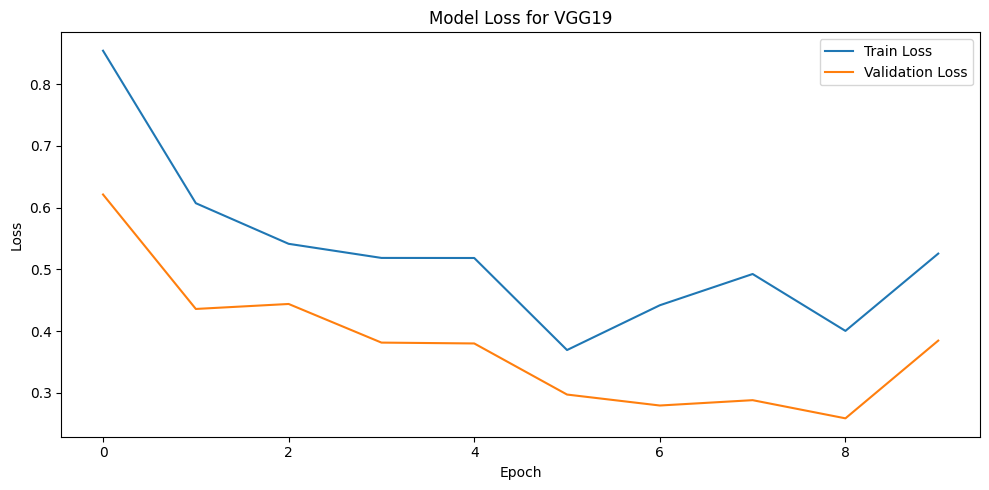

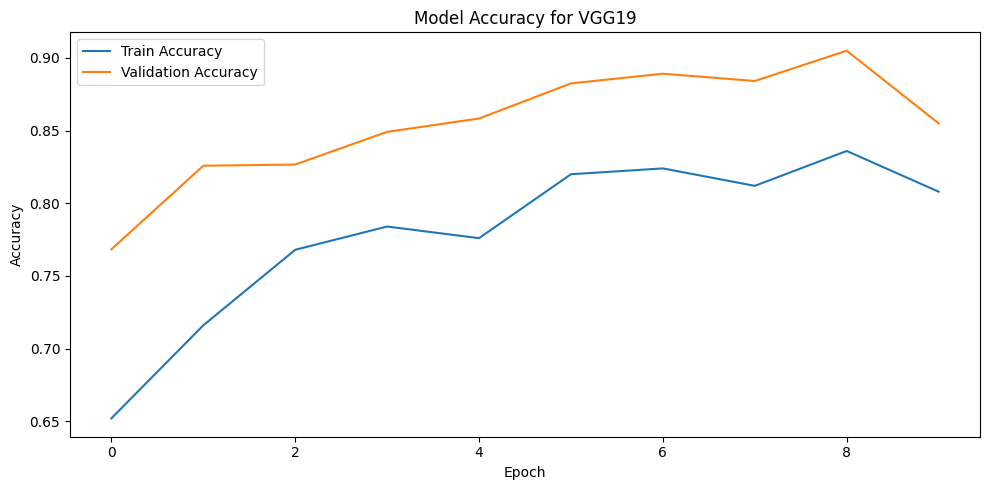

In [22]:
plot_history(vgg19_history, 'VGG19')

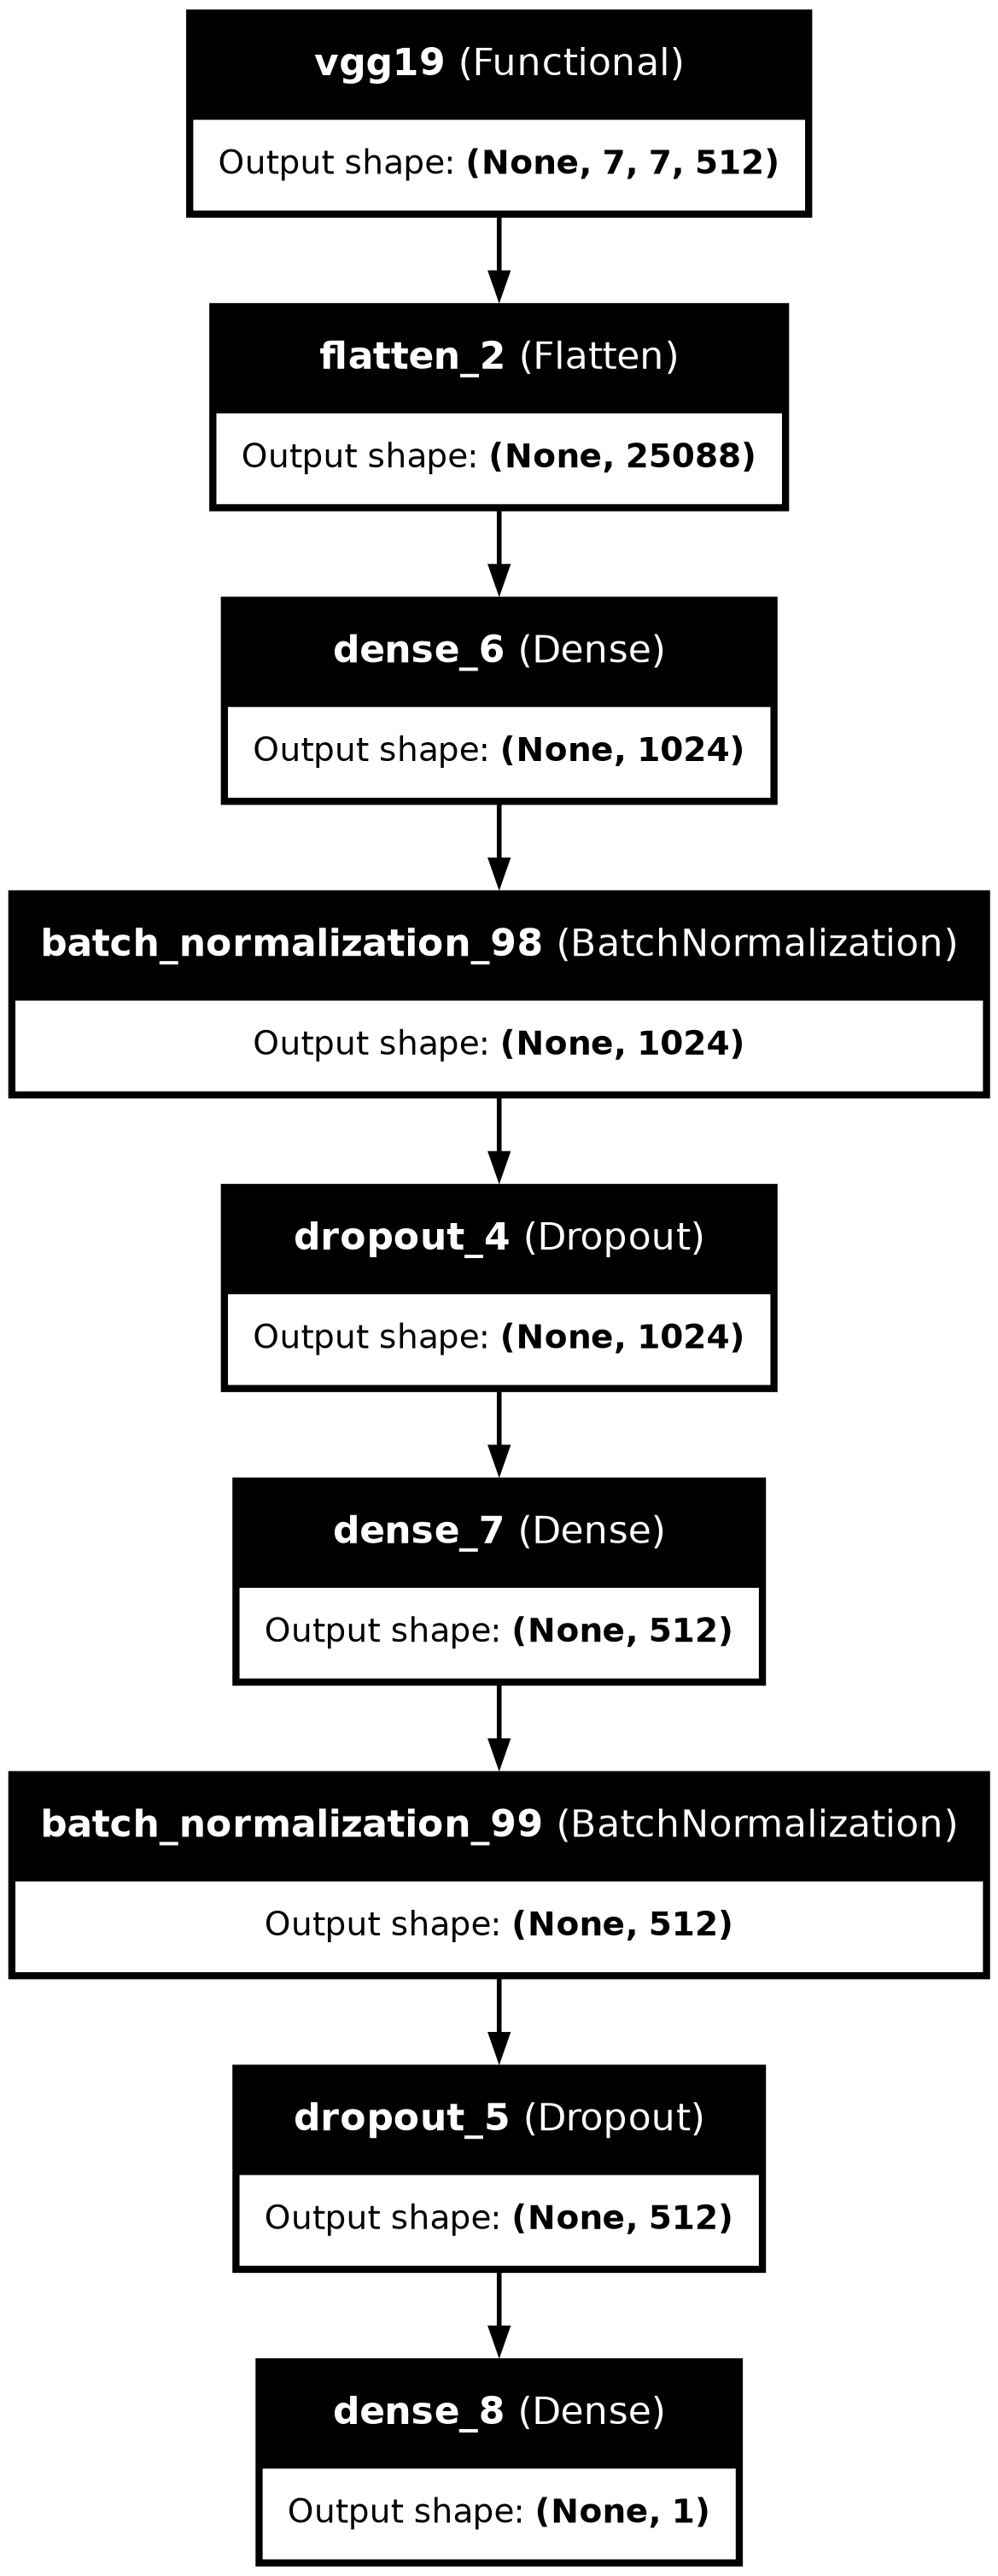

In [21]:
plot_model(trained_vgg19, to_file='vgg19_model_architecture.png', show_shapes=True, show_layer_names=True)

In [24]:
def cnn_model(df, train, val, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(dataframe=train, x_col='Image_Path', y_col='Labels', class_mode='binary', target_size=(134,134), shuffle=True, batch_size = 10,seed=10)
    x_val = img_datagen.flow_from_dataframe(dataframe=val,x_col='Image_Path',y_col='Labels',class_mode='binary',target_size=(134, 134),shuffle=True,batch_size = 10,seed=10)
    x_test = img_datagen.flow_from_dataframe(dataframe=test, x_col = 'Image_Path', y_col = 'Labels', class_mode = 'binary', target_size = (134, 134), shuffle = False, batch_size = 10, seed = 10)
  
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(134, 134, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    his = model.fit(x_train, steps_per_epoch = 25, epochs=10, validation_data=x_val,callbacks=my_callbacks)

    pred_cnn = model.predict(x_test)
    pred_cnn = np.round(pred_cnn)

    y_pred = model.predict(x_test)
    y_pred_binary = np.round(y_pred)
    
    cm = confusion_matrix(x_test.labels, y_pred_binary)
    
    f1 = f1_score(x_test.labels, y_pred_binary)
    accuracy = accuracy_score(x_test.labels, y_pred_binary)
    precision = precision_score(x_test.labels, y_pred_binary)
    recall = recall_score(x_test.labels, y_pred_binary)

    return model, classification_report(x_test.labels, pred_cnn), his, f1, accuracy, precision, recall

trained_cnn, cnn_scores, cnn_history, cnn_f1, cnn_acc, cnn_precision, cnn_recall = cnn_model(df, train, val, test, my_callbacks)

Found 2800 validated image filenames belonging to 2 classes.

Found 1200 validated image filenames belonging to 2 classes.

Found 1000 validated image filenames belonging to 2 classes.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 950ms/step - accuracy: 0.4962 - loss: 7.4317 - val_accuracy: 0.5050 - val_loss: 5.1802

Epoch 2/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 919ms/step - accuracy: 0.5248 - loss: 2.5536 - val_accuracy: 0.5058 - val_loss: 1.4263

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step


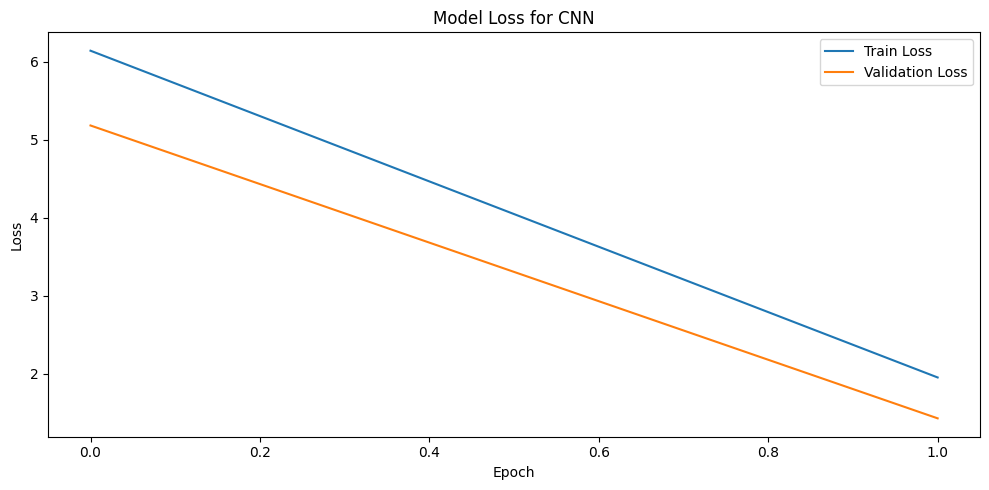

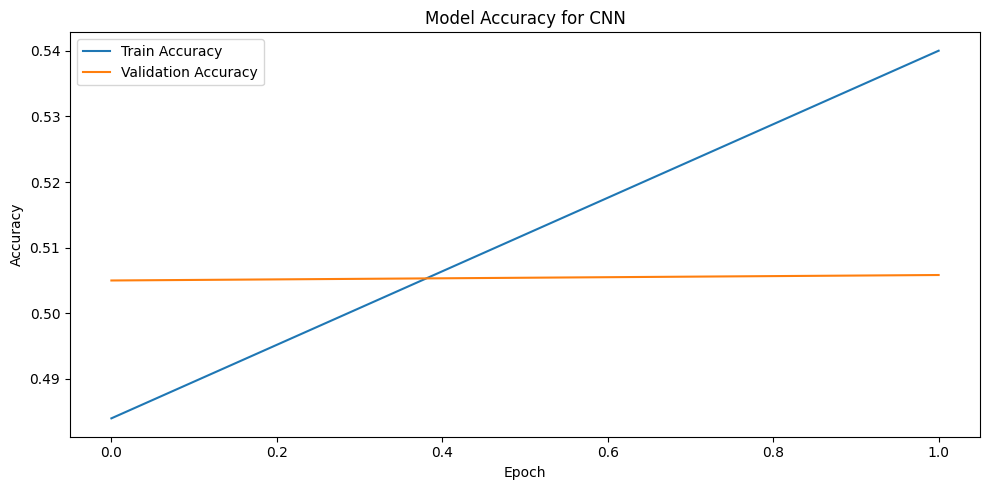

In [25]:
plot_history(cnn_history, 'CNN')

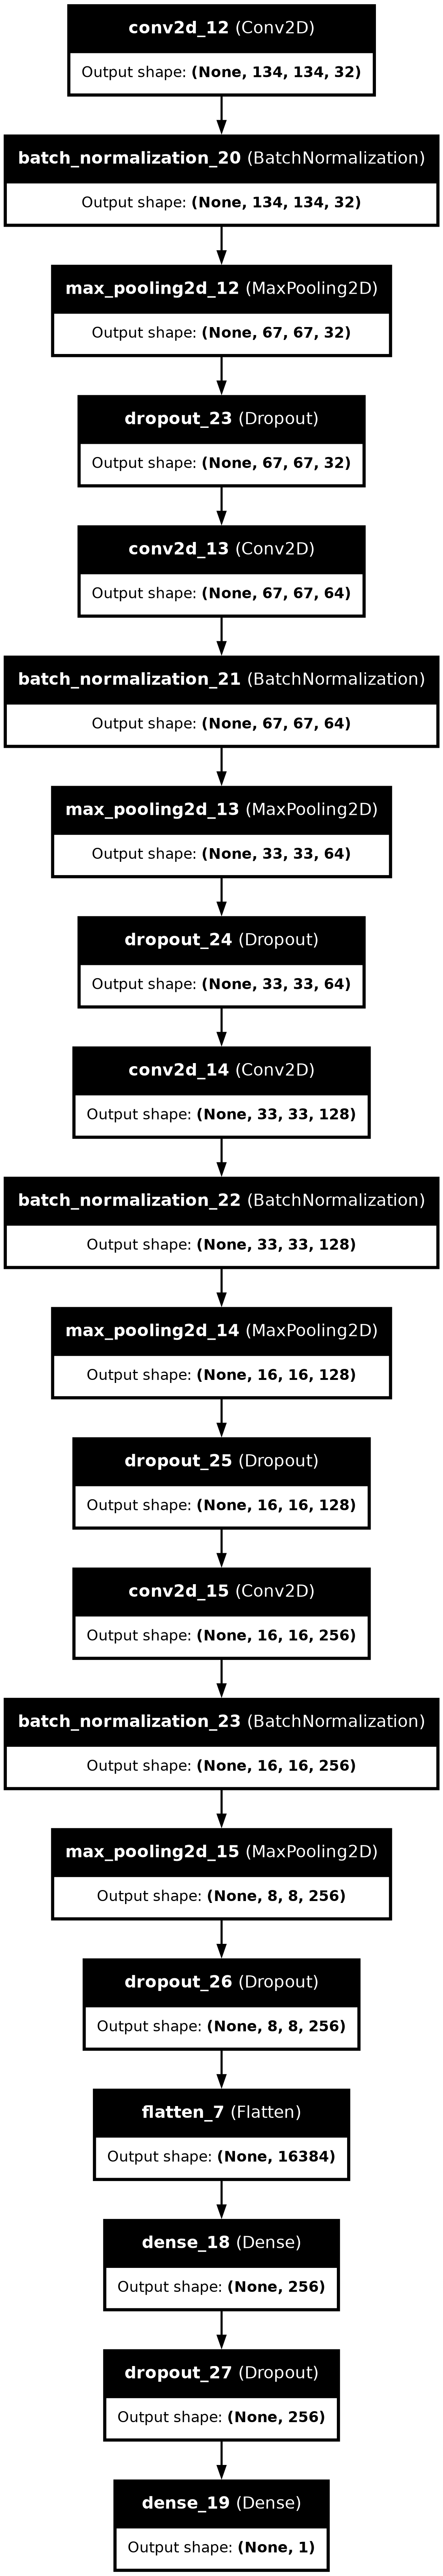

In [39]:
plot_model(trained_cnn, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)

In [9]:
resnet_weight = '/kaggle/input/resnet-weight-frfr/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

def resnet_model(df, train,val, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(dataframe=train, x_col='Image_Path', y_col='Labels', class_mode='binary', target_size=(64,64), shuffle=True, seed=10)
    x_val = img_datagen.flow_from_dataframe(dataframe=val,x_col='Image_Path',y_col='Labels',class_mode='binary',target_size=(64, 64),shuffle=True,seed=10)
    x_test = img_datagen.flow_from_dataframe(dataframe=test, x_col = 'Image_Path', y_col = 'Labels', class_mode = 'binary', target_size = (64, 64), shuffle = False, seed = 10)

    resnet_model=resnet50.ResNet50(weights= resnet_weight,include_top=False,input_shape=(64,64,3))

    for layer in resnet_model.layers:
        layer.trainable = False

    model = Sequential([
    resnet_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer= l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer= l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

    his = model.fit(x_train, steps_per_epoch= 25, validation_data=x_val, epochs = 10, callbacks=my_callbacks)

    pred_resnet = model.predict(x_test)
    pred_resnet = np.round(pred_resnet)

    accuracy = accuracy_score(x_test.labels, pred_resnet)
    precision = precision_score(x_test.labels, pred_resnet)
    recall = recall_score(x_test.labels, pred_resnet)
    f1 = f1_score(x_test.labels, pred_resnet)

    return model, classification_report(x_test.labels, pred_resnet), his, f1, accuracy, precision, recall

trained_resnet, resnet_scores, resnet_history, resnet_f1, resnet_acc, resnet_precision, resnet_recall = resnet_model(df, train, val, test, my_callbacks)

Found 2800 validated image filenames belonging to 2 classes.

Found 1200 validated image filenames belonging to 2 classes.

Found 1000 validated image filenames belonging to 2 classes.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 910ms/step - accuracy: 0.6917 - loss: 2.0227 - val_accuracy: 0.8308 - val_loss: 1.7637

Epoch 2/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 750ms/step - accuracy: 0.8192 - loss: 1.7307 - val_accuracy: 0.8650 - val_loss: 1.6751

Epoch 3/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 728ms/step - accuracy: 0.8353 - loss: 1.6645 - val_accuracy: 0.8408 - val_loss: 1.7110

Epoch 4/10

13/25 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.8544 - loss: 1.6808

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.8481 - loss: 1.6802 - val_accuracy: 0.8467 - val_loss: 1.7297

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step


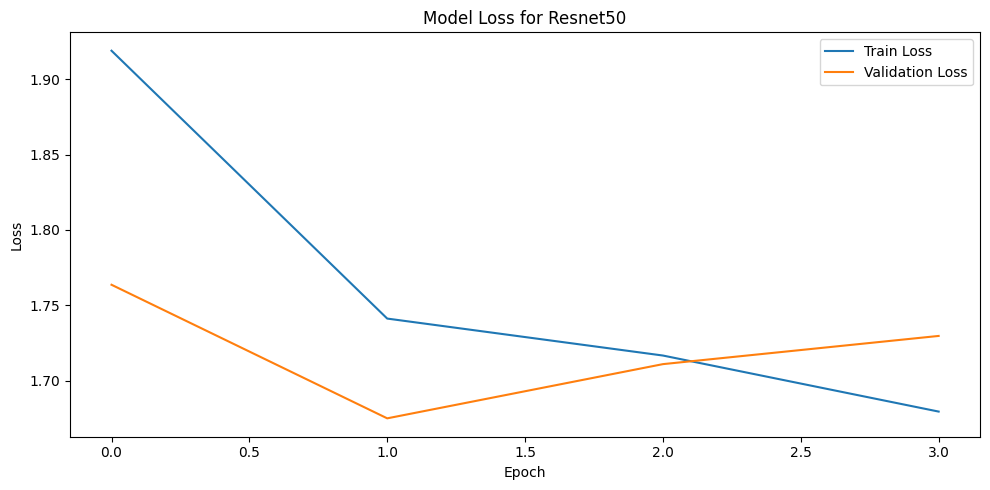

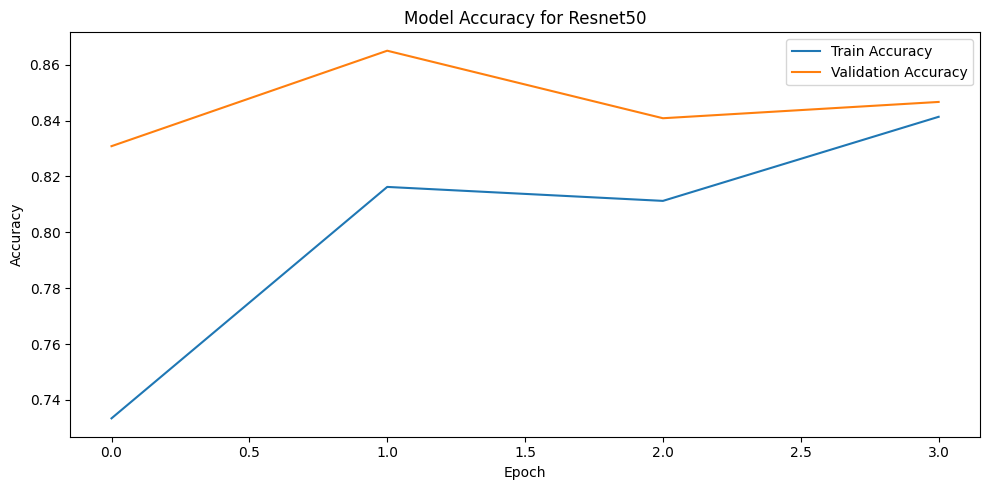

In [10]:
plot_history(resnet_history, 'Resnet50')

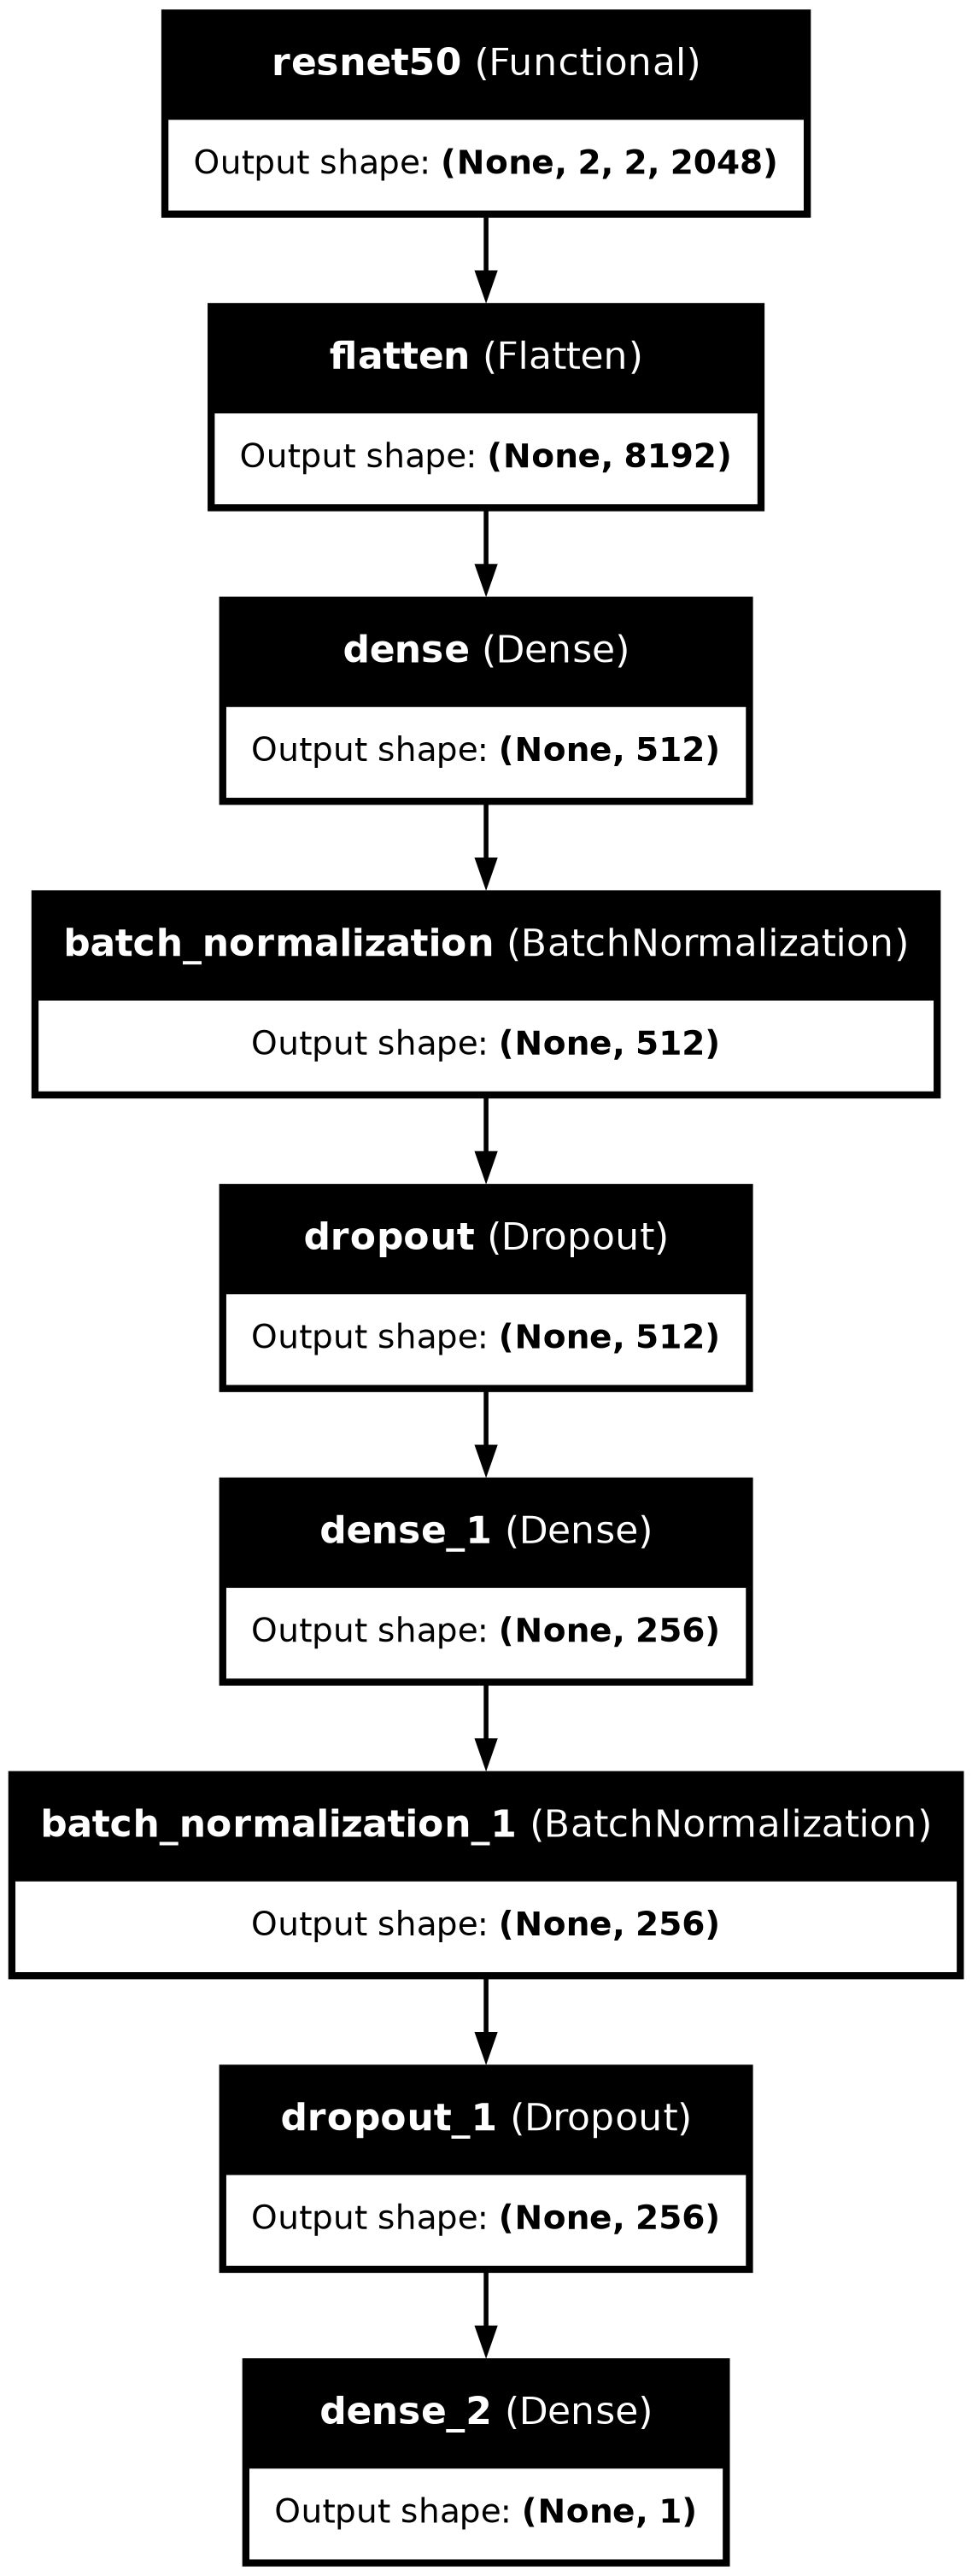

In [11]:
plot_model(trained_resnet, to_file='resnet_model_architecture.png', show_shapes=True, show_layer_names=True)

In [29]:
inception_weight = '/kaggle/input/inception-weight/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

def inception_v3_model(df, train, val, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(dataframe=train, x_col='Image_Path', y_col='Labels', class_mode='binary', target_size=(299,299), shuffle=True, seed=10)
    x_val = img_datagen.flow_from_dataframe(dataframe=val,x_col='Image_Path',y_col='Labels',class_mode='binary',target_size=(299, 299),shuffle=True,seed=10)
    x_test = img_datagen.flow_from_dataframe(dataframe=test, x_col = 'Image_Path', y_col = 'Labels', class_mode = 'binary', target_size = (299, 299), shuffle = False, seed = 10)

    inception_model = InceptionV3(input_shape=(299, 299,3), weights= inception_weight,include_top=False)

    for layer in inception_model.layers:
        layer.trainable = False

    model = Sequential([
      inception_model,
      Flatten(),
      Dense(512, activation='relu', kernel_regularizer= l2(0.001)),
      BatchNormalization(),
      Dropout(0.5),
      Dense(256, activation='relu', kernel_regularizer= l2(0.001)),
      BatchNormalization(),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

    his = model.fit(x_train, steps_per_epoch=25, validation_data=x_val, epochs = 10 , callbacks=my_callbacks)

    pred_incept = model.predict(x_test)
    pred_incept = np.round(pred_incept)

    accuracy = accuracy_score(x_test.labels, pred_incept)
    precision = precision_score(x_test.labels, pred_incept)
    recall = recall_score(x_test.labels, pred_incept)
    f1 = f1_score(x_test.labels, pred_incept)

    return model, classification_report(x_test.labels, pred_incept), his, f1, accuracy, precision, recall

trained_inception, inception_scores, inception_history, inception_f1, inception_acc, inception_precision, inception_recall = inception_v3_model(df, train, val, test, my_callbacks)

Found 2800 validated image filenames belonging to 2 classes.

Found 1200 validated image filenames belonging to 2 classes.

Found 1000 validated image filenames belonging to 2 classes.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 309s 12s/step - accuracy: 0.6183 - loss: 2.2529 - val_accuracy: 0.5650 - val_loss: 3.9877

Epoch 2/10

25/25 ━━━━━━━━━━━━━━━━━━━━ 283s 12s/step - accuracy: 0.6095 - loss: 2.2703 - val_accuracy: 0.6000 - val_loss: 2.7879

32/32 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step


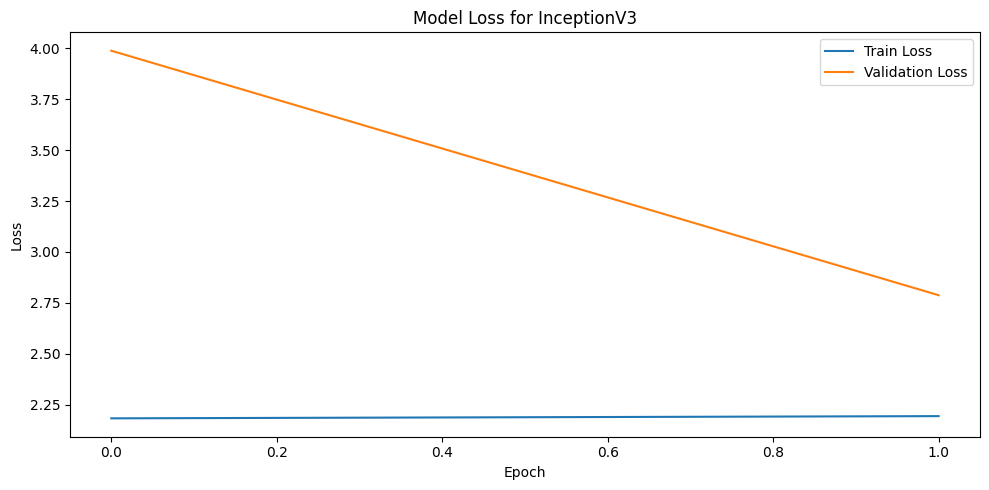

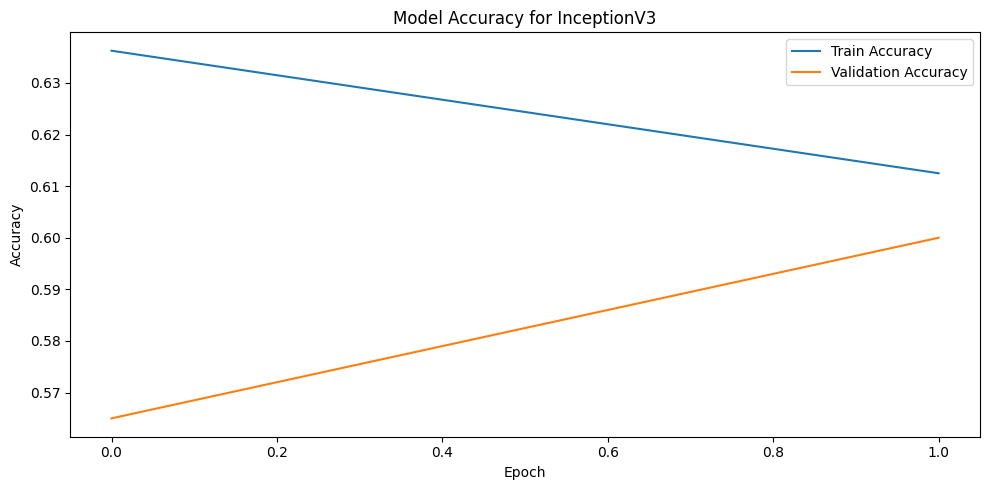

In [30]:
plot_history(inception_history, 'InceptionV3')

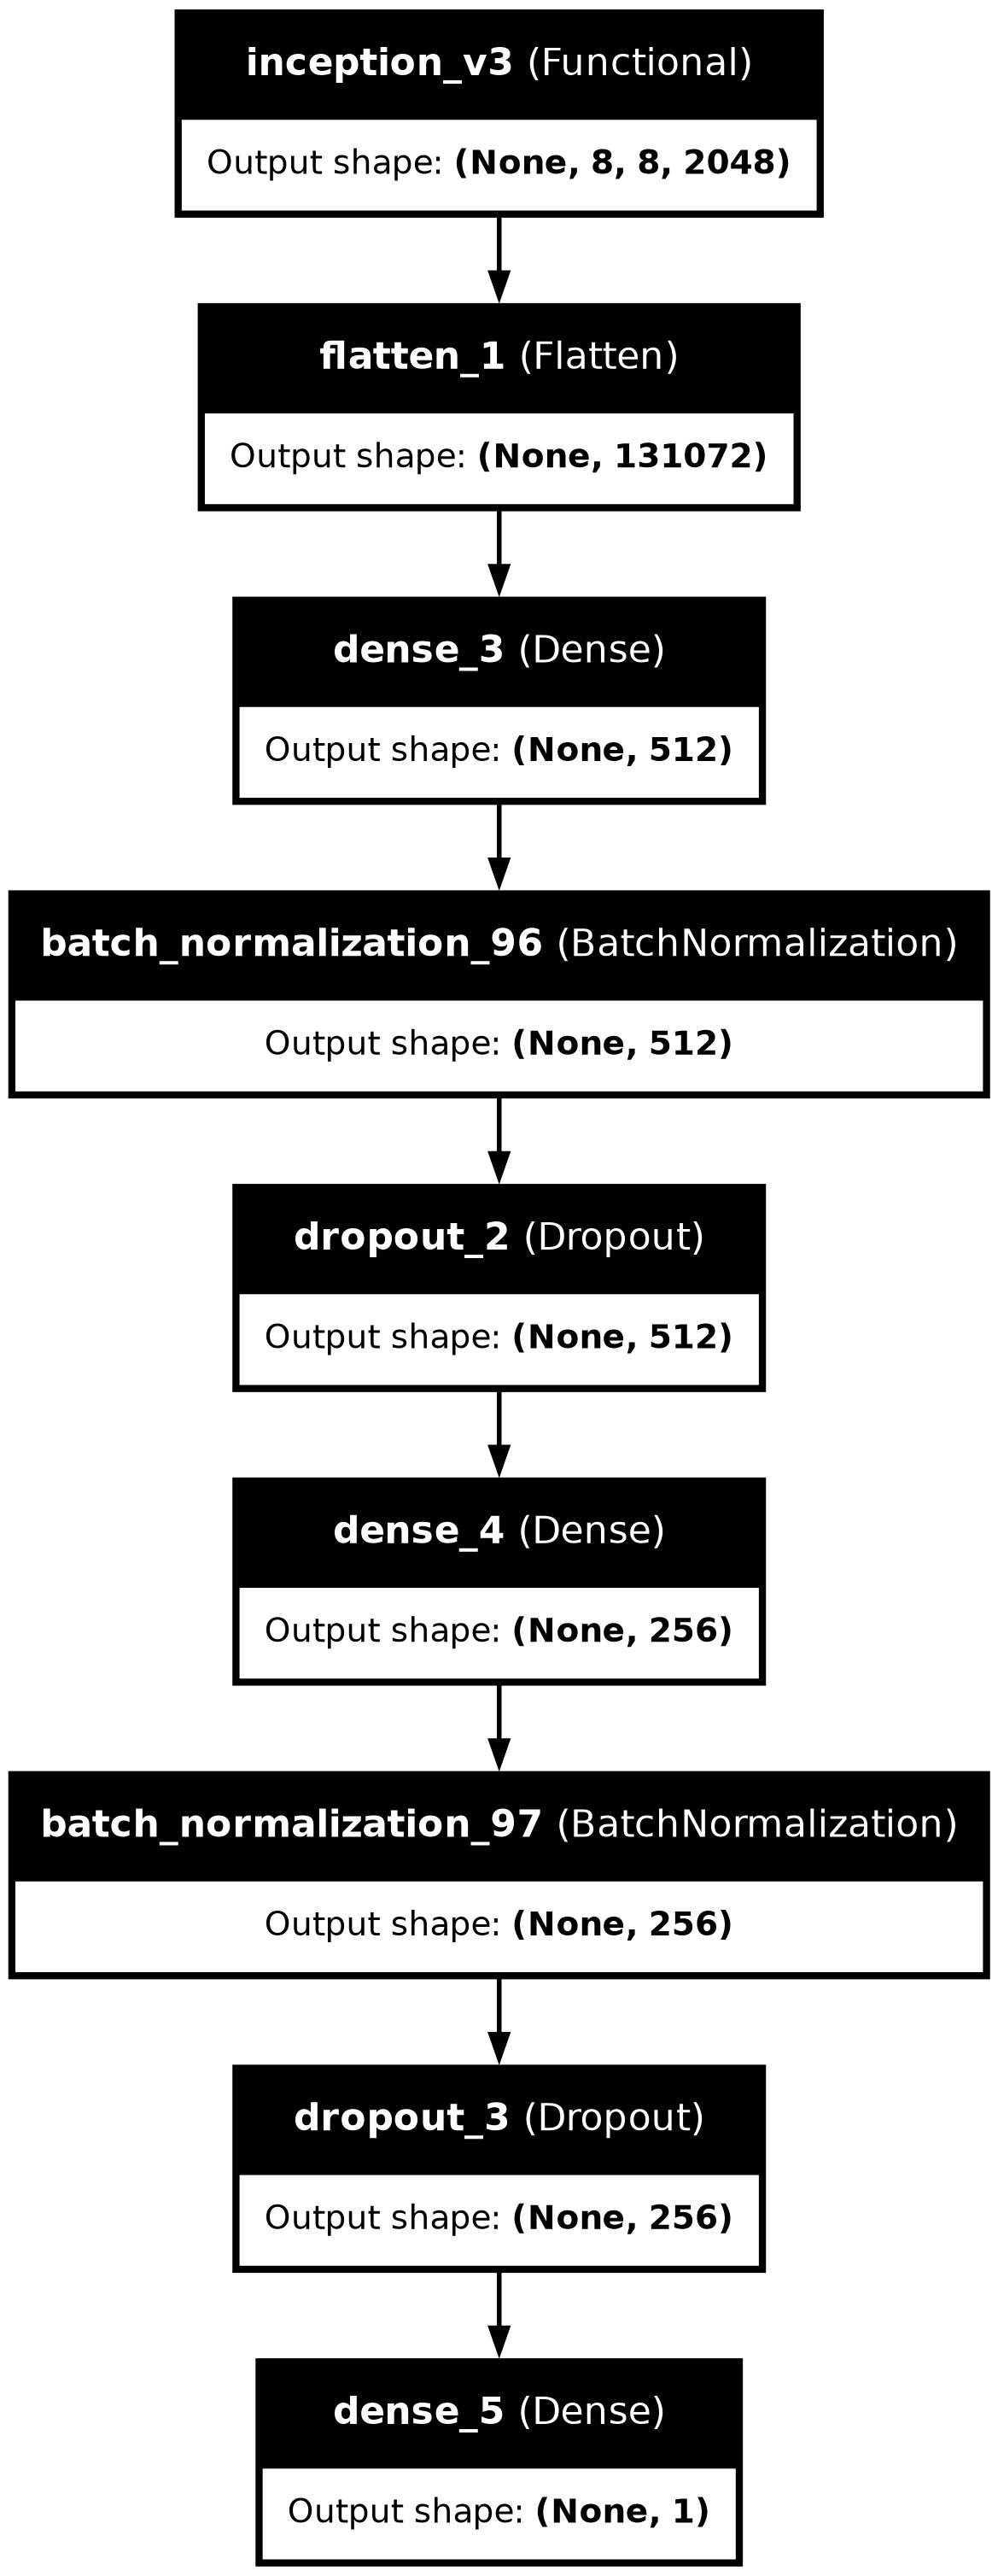

In [14]:
plot_model(trained_inception, to_file='inception_model_architecture.png', show_shapes=True, show_layer_names=True)

In [32]:
vgg19_metrics = {'Model': 'VGG19', 'Accuracy': vgg19_acc, 'Precision': vgg19_precision, 'Recall': vgg19_recall, 'F1 Score': vgg19_f1}
cnn_metrics = {'Model': 'CNN', 'Accuracy': cnn_acc, 'Precision': cnn_precision, 'Recall': cnn_recall, 'F1 Score': cnn_f1}
resnet_metrics = {'Model': 'ResNet', 'Accuracy': resnet_acc, 'Precision': resnet_precision, 'Recall': resnet_recall, 'F1 Score': resnet_f1}
inception_metrics = {'Model': 'Inception', 'Accuracy': inception_acc, 'Precision': inception_precision, 'Recall': inception_recall, 'F1 Score': inception_f1}

metrics_df = pd.DataFrame([vgg19_metrics, cnn_metrics, resnet_metrics, inception_metrics])
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,VGG19,0.859,0.794830,0.972332,0.874667
1,CNN,0.519,0.566845,0.209486,0.305916
2,ResNet,0.821,0.945504,0.685771,0.794960
3,Inception,0.601,0.562720,0.948617,0.706402
